In [3]:
import sys
import time
import copy

from itertools import repeat
import data, data.gene_datasets
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import gene_inference, gene_inference.utils
from gene_inference.models import lr, mlp, decision_tree
from gene_inference.infer_genes import infer_gene, infer_all_genes, sample_neighbors
import models, models.graphLayer
from models.models import CGN
import data, data.gene_datasets
from data.graph import Graph
from data.utils import split_dataset
import optimization as otim
import torch
from torch.autograd import Variable
from analysis.metrics import record_metrics_for_epoch
import analysis
reload(analysis.metrics)
reload(gene_inference)

/u/weissmar/venv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'gene_inference' from 'gene_inference/__init__.pyc'>

In [5]:
#tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')
tcgatissue = data.gene_datasets.TCGATissue()

Converting one-hot labels to integers


In [6]:
class Object(object):
    pass

opt = Object()
opt.seed = 0
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = tcgatissue
opt.add_self = True
opt.norm_adj = True
opt.add_connectivity = True
opt.num_layer = 1
opt.cuda = True
opt.pool_graph = "ignore"


In [7]:
graph = Graph()
path = "/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5"
graph.load_graph(path)
#graph.intersection_with(tcgatissue)
g = nx.from_numpy_matrix(graph.adj)
mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
g = nx.relabel_nodes(g, mapping)

In [8]:
def cgn_loop(dataset, trials, train_size, test_size, penalty=False, num_epochs=100, num_channel=None, num_layer=None, add_emb=None, use_gate=False, dropout=True, cuda=False, adj=None):
    scores = []
   
    labels = torch.LongTensor(dataset.labels)
    criterions = otim.get_criterion(dataset)
    train_ratio = float(train_size) / (2 * test_size + train_size)
    train_set, valid_set, test_set = split_dataset(dataset, batch_size=10, random=True, train_ratio=train_ratio, seed=1, nb_samples=train_size + 2 * test_size, nb_per_class=None)
    for trial in range(trials):
        patience = 20
        opt.num_layer = num_layer
        adj_transform, aggregate_function = models.graphLayer.get_transform(opt, adj)
        model = models.models.CGN(
                nb_nodes=len(dataset.df.columns), 
                input_dim=1,
                channels=[num_channel] * num_layer,
                adj=adj,
                out_dim=2,
                on_cuda=cuda,
                add_emb=add_emb,
                transform_adj=adj_transform,
                aggregate_adj=aggregate_function,
                use_gate=use_gate,
                dropout=dropout,
                )
        if cuda:
            torch.cuda.manual_seed(trial)
            torch.cuda.manual_seed_all(trial)
            model.cuda()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        max_valid = 0
        for t in range(0, num_epochs):
            start_timer = time.time()
            for no_b, mini in enumerate(train_set):
                inputs, labels = mini['sample'], mini['labels']

                inputs = Variable(inputs, requires_grad=False).float()
                if cuda:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                model.train()
                y_pred = model(inputs)

                # Compute and print loss
                crit_loss = otim.compute_loss(criterions, y_pred, labels)
                total_loss = crit_loss

                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                crit_loss.backward()
                optimizer.step()
                model.eval()
            time_this_epoch = time.time() - start_timer
            acc, auc = record_metrics_for_epoch(None, crit_loss, total_loss, t, time_this_epoch, train_set, valid_set, test_set, model, dataset, cuda=True)
            summary = [
                t,
                crit_loss.data[0],
                acc['train'],
                acc['valid'],
                auc['train'],
                auc['valid'],
                time_this_epoch
            ]
            summary = "epoch {}, cross_loss: {:.03f}, acc_train: {:0.3f}, acc_valid: {:0.3f}, auc_train: {:0.3f}, auc_valid:{:0.3f}, time: {:.02f} sec".format(*summary)
            print summary

            patience = patience - 1
            if patience == 0:
                break
            if max_valid < auc['valid']:
                max_valid = auc['valid']
            if max_valid > auc['valid'] and t > 15:
                scores.append(auc['test']) 
                break

    return np.round(np.mean(scores), 2),  np.round(np.std(scores), 2)

In [9]:
def take_gene_subset(dataset, gene, num_genes, include_self=False):
    neighbors = sample_neighbors(g, gene, num_genes, include_self=False)
    dataset.df = dataset.df.drop(gene, axis=1)
    dataset.df = dataset.df.loc[:, neighbors]
    dataset.df = dataset.df - dataset.df.mean()
    dataset.data = dataset.df.as_matrix()

lines = []
def method_comparison_vary_genes(dataset, models, gene="RPL5", max_genes=150, trials=10, train_size=100, test_size=100, penalty=True, step=10):
    # Predict a gene from a growing number of Nodes
    results_df = pd.DataFrame(columns=['model', 'num_genes', 'num_trials'])
    mean = dataset.df[gene].mean()
    dataset.labels = [1 if x > mean else 0 for x in dataset.df[gene]]
    full_df = dataset.df.copy(deep=True)
    for num_genes in range(10, max_genes, step):
        results = []
        dataset.df = full_df
        dataset.df = take_gene_subset(dataset, gene, num_genes, include_self=False)
        neighborhood = np.asarray(nx.to_numpy_matrix(nx.Graph(g.subgraph(neighbors))))
        
        for model in models:
            results = model['method'](dataset, trials, train_size, test_size, penalty=penalty, num_channel=model.get('num_channel'), num_layer=model.get('num_layer'), add_emb=model.get('add_emb'), use_gate=model.get('use_gate'), dropout=model.get('dropout'), cuda=model.get('cuda'), adj=neighborhood)
            data = {"gene_name": gene,
                    "auc": results[0],
                    "std": results[1]
                    }
            row = pd.DataFrame(data, [0])
            results_df = results_df.append(row).reset_index(drop=True)
            results_df.loc[results_df.index[-1], 'num_genes'] = num_genes
            results_df.loc[results_df.index[-1], 'model'] = model['key']
            results_df.loc[results_df.index[-1], 'num_trials'] = trials
            print results_df
        dataset.df = full_df
    
    plt.figure()
    titles = []
    for model in models:
        temp_results = results_df.loc[results_df['model'] == model['key']].reset_index(drop=True)
        lines.append(plt.errorbar(temp_results.index, temp_results['auc'], xerr=0, yerr=temp_results['std'])[0])
        titles.append(model['key'])
        plt.xticks(list(temp_results.index), temp_results['num_genes'], rotation=70)
    width = 0.2
    plt.title("Gene Inference with varying numbers of nodes")
    plt.ylabel("AUC")
    plt.xlabel("number of nodes")
    plt.legend(lines, titles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

In [12]:
reload(data)
reload(models.models)
reload(gene_inference)
reload(gene_inference.models)
reload(analysis.metrics)
tcgatissue = data.gene_datasets.TCGATissue()
m = [
    {'key': 'LR', 'method': lr},
    {'key': 'MLP', 'method': mlp},
    {'key': 'Decision Tree', 'method': decision_tree},
    {'key': 'CGN_3_layer_64_channel_emb_32_dropout', 'method': cgn_loop, 'num_channel': 64, 'num_layer': 3, 'add_emb': 32, 'use_gate': False, 'dropout': True, 'cuda': True},
    ]



Converting one-hot labels to integers


In [ ]:
method_comparison(tcgatissue, m, gene="RPL5", max_genes=4000, trials=5, train_size=100, test_size=1000, penalty=True)

TypeError: method_comparison() got an unexpected keyword argument 'step'

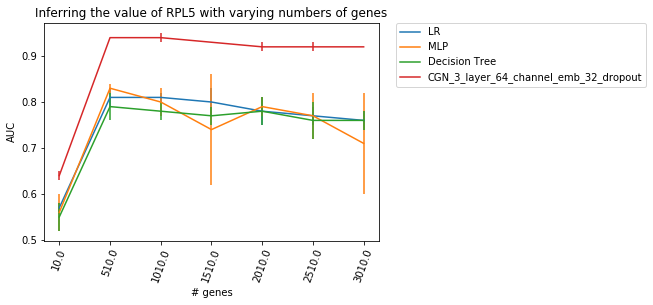

In [10]:
#results_df = pd.DataFrame(columns=['model', 'num_genes', 'gene_name', 'auc', 'std'])
#results_df = results_df.append(data=pd.DataFrame(pd.DataFrame(data={'model':"LR", 'num_genes': 10.0, 'gene_name': "RPL5", 'auc':0.57, 'std': 0.01}, index=[0]))
len(["LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout"])
len([10.0, 10.0, 10.0, 10.0, 510.0, 510.0, 510.0, 510.0, 1010.0, 1010.0, 1010.0, 1010.0, 1510.0, 1510.0, 1510.0, 1510.0, 2010.0, 2010.0, 2010.0, 2010.0, 2510.0, 2510.0, 2510.0, 2510.0, 3010.0, 3010.0, 3010.0, 3010.0])
len([0.57, 0.56, 0.55, 0.64, 0.81, 0.83, .79, .94, .81, .80, .78, .94, .80, .74, .77, .93, .78, .79, .78, .92, .77, .77, .76, .92, .76, .71, .76, .92])
len([0.01, 0.04, 0.03, 0.01, 0.02, 0.01, 0.03, 0.00, 0.01, 0.03, 0.02, 0.01, 0.03, 0.12, 0.02, 0.00, 0.03, 0.02, 0.03, 0.01, 0.02, 0.05, 0.04, 0.01, 0.02 ,0.11, 0.02, 0.00])
results_df = pd.DataFrame(data={'model':["LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout"],
                   'num_genes': [10.0, 10.0, 10.0, 10.0, 510.0, 510.0, 510.0, 510.0, 1010.0, 1010.0, 1010.0, 1010.0, 1510.0, 1510.0, 1510.0, 1510.0, 2010.0, 2010.0, 2010.0, 2010.0, 2510.0, 2510.0, 2510.0, 2510.0, 3010.0, 3010.0, 3010.0, 3010.0],
#                  'gene_name': ["RPL5", "RPL5"],
                   'auc': [0.57, 0.56, 0.55, 0.64, 0.81, 0.83, .79, .94, .81, .80, .78, .94, .80, .74, .77, .93, .78, .79, .78, .92, .77, .77, .76, .92, .76, .71, .76, .92],
                   'std': [0.01, 0.04, 0.03, 0.01, 0.02, 0.01, 0.03, 0.00, 0.01, 0.03, 0.02, 0.01, 0.03, 0.12, 0.02, 0.00, 0.03, 0.02, 0.03, 0.01, 0.02, 0.05, 0.04, 0.01, 0.02 ,0.11, 0.02, 0.00]}, index=range(0, 28))
plt.figure()
titles = []
for model in [
    {'key': 'LR', 'method': lr},
    {'key': 'MLP', 'method': mlp},
    {'key': 'Decision Tree', 'method': decision_tree},
    {'key': 'CGN_3_layer_64_channel_emb_32_dropout', 'method': cgn_loop, 'num_channel': 64, 'num_layer': 3, 'add_emb': 32, 'use_gate': False, 'dropout': True, 'cuda': True},
    ]:
    temp_results = results_df.loc[results_df['model'] == model['key']].reset_index(drop=True)
    lines.append(plt.errorbar(temp_results.index, temp_results['auc'], xerr=0, yerr=temp_results['std'])[0])
    titles.append(model['key'])
    plt.xticks(list(temp_results.index), temp_results['num_genes'], rotation=70)
width = 0.2
plt.title("Inferring the value of RPL5 with varying numbers of genes")
plt.ylabel("AUC")
plt.xlabel("# genes")
plt.legend(lines, titles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)


In [ ]:
# results of adding Nodes
plt.figure()

#full_results.loc[full_results['samples'] == 100]

line1 = plt.errorbar(lr_results.index, lr_results['auc'], xerr=0, yerr=lr_results['std'])
line2 = plt.errorbar(cgn_results.index, cgn_results['auc'], xerr=0, yerr=cgn_results['std'])

width = 0.2
plt.xticks(list(lr_results.iloc[::5, :].index), lr_results.iloc[::5, :]['num_genes'], rotation=70)
plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("number of nodes")
plt.legend((line1[0], line2[0]), ('LR', "CGN"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

In [ ]:
# Predict a gene from a growing number of Nodes
lr_results = pd.DataFrame([])
mlp_results = pd.DataFrame([])
cgn_results = pd.DataFrame([])
gene = "RPL5"
max_samples = 200
reload(data)
reload(models)
tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')

for num_samples in range(10, max_samples, 20):
    lr_row = infer_gene(lr, tcgatissue, "RPL5", train_size=num_samples, test_size=200, trials=3, penalty=True)
    lr_results = lr_results.append(lr_row).reset_index(drop=True)
    lr_results.loc[lr_results.index[-1], 'num_samples'] = num_samples
    cgn_row = infer_gene(cgn, tcgatissue, "RPL5", train_size=num_samples, test_size=200, trials=3, penalty=True)
    cgn_results = cgn_results.append(cgn_row).reset_index(drop=True)
    cgn_results.loc[lr_results.index[-1], 'num_samples'] = num_samples
    print num_genes
    print cgn_results
    print lr_results

In [ ]:
# results of adding Nodes
plt.figure()

#full_results.loc[full_results['samples'] == 100]

line1 = plt.errorbar(lr_results.index, lr_results['auc'], xerr=0, yerr=lr_results['std'])
line2 = plt.errorbar(cgn_results.index, cgn_results['auc'], xerr=0, yerr=cgn_results['std'])

width = 0.2
plt.xticks(list(lr_results.iloc[::5, :].index), lr_results.iloc[::5, :]['num_samples'], rotation=70)
plt.title("Gene Inference with varying numbers of samples")
plt.ylabel("AUC")
plt.xlabel("number of samples")
plt.legend((line1[0], line2[0]), ('LR', "CGN"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)